In [7]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import StandardScaler
from utils import *
#from skimage.transform import resize
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
import joblib
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

from collections import Counter

from itertools import dropwhile, cycle

from sklearn.preprocessing import LabelBinarizer, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



# Loading Data

In [ ]:
diretorio_treinamento = 'CAPTCHA-10k/CAPTCHA-10k/treinamento'
diretorio_validacao = 'CAPTCHA-10k/CAPTCHA-10k/validacao'
diretorio_teste = 'CAPTCHA-10k/CAPTCHA-10k/teste'
diretorio_labels = 'CAPTCHA-10k/CAPTCHA-10k/labels10k'

df_treino = carregar_dados(diretorio_treinamento, diretorio_labels)
df_val = carregar_dados(diretorio_validacao, diretorio_labels)
df_teste = carregar_dados(diretorio_teste, diretorio_labels)

df_treino = filer_df(df_treino)
df_teste = filer_df(df_teste)
df_val = filer_df(df_val)


In [ ]:
df_treino = preprocess_df(df_treino)
df_teste = preprocess_df(df_teste)
df_val = preprocess_df(df_val)

# Plot image

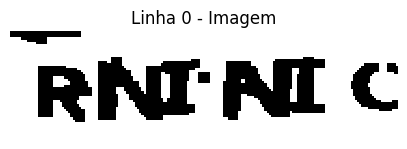

In [8]:
plot_image(df_treino,0)

# Train data

Preparing data for train and test

In [ ]:
X_train = []
y_train = []

for idx, row in df_treino.iterrows():
    imagem = row["imagem"]
    rotulo = row["rotulo"]

    subimagens = split_image_in_chars(imagem)

    caracteres = list(rotulo)

    for sub_img, ch in zip(subimagens, caracteres):
        X_train.append(sub_img)
        y_train.append(ch)

X_train, y_train = prepare_data(df_treino)
X_val, y_val = prepare_data(df_val)
X_teste, y_teste = prepare_data(df_teste)

In [41]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_teste = np.expand_dims(X_teste, axis=-1)

In [42]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_teste = lb.transform(y_teste)
y_val = lb.transform(y_val)

Training set (47394, 36)
Test set (5994, 36)
Validation set (5994, 36)


## Training

In [15]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
    print(f"Using GPU: {gpus}")
else:
    print("No GPU available, using CPU.")


GPUs available: 2
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [43]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define the model
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), input_shape=(50, 40, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional block
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional block
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fifth convolutional block
    model.add(Conv2D(64, (1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # Fifth convolutional block
    model.add(Conv2D(64, (1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # Flatten layer to transition from convolutional to fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(64, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(36, activation='softmax'))

    # Model summary and compilation
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 50, 40, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 50, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 50, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 50, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 25, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 25, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 25, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 25, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 25, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 12, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 12, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_26 (LeakyReLU)           │ (None, 12, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 12, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 6, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 6, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_27 (LeakyReLU)           │ (None, 6, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 6, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 470,756 (1.80 MB)

 Trainable params: 469,540 (1.79 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [11]:
# Define the checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [44]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=512),
    validation_data=(X_val, y_val),
    epochs=100,
    verbose=1,
    callbacks=[checkpoint]
)

test_loss, test_acc = model.evaluate(X_teste, y_teste)
print(f'Test accuracy: {test_acc * 100:.2f}%')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.2298 - loss: 4.9566
Epoch 1: val_accuracy did not improve from 0.92626
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.2323 - loss: 4.9421 - val_accuracy: 0.5405 - val_loss: 2.4973
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8390 - loss: 1.4422
Epoch 2: val_accuracy did not improve from 0.92626
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.8392 - loss: 1.4402 - val_accuracy: 0.8549 - val_loss: 1.4847
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8976 - loss: 0.8994
Epoch 3: val_accuracy did not improve from 0.92626
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.8976 - loss: 0.8988 - val_accuracy: 0.8919 - val_loss: 1.2071
Epoch 4/100
40/93 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.9153 - loss: 0.7145

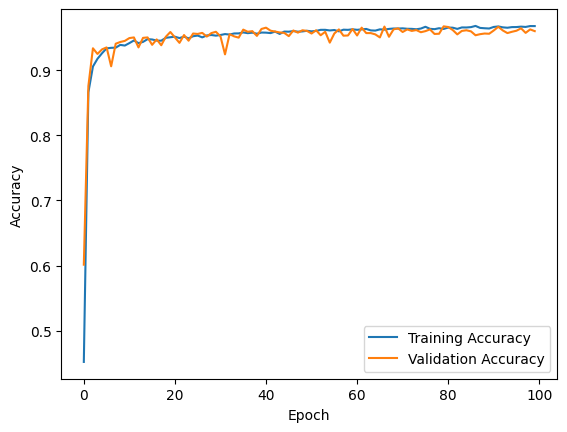

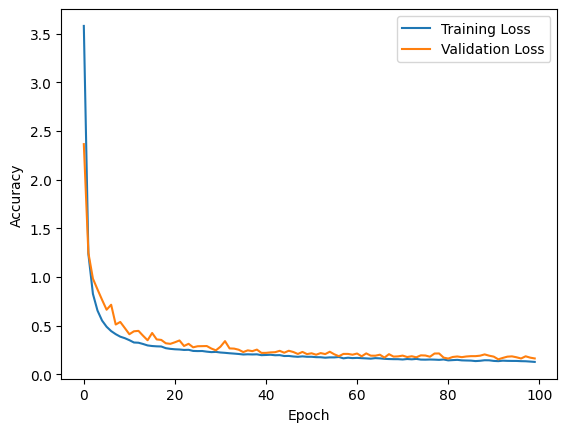

In [36]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Testing

In [27]:
best_model = load_model('best_model.keras')

In [28]:
y_pred = best_model.predict(X_teste)

# Binarize the true labels
y_test_bin = label_binarize(y_teste, classes=np.arange(36))

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
# Convert probabilities to class labels
target_names = [str(label) for label in lb.classes_]
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_teste, axis=1)

    # Print classification report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=target_names))

# Calculate overall accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       177
           1       0.96      0.93      0.94       170
           2       0.99      0.99      0.99       162
           3       0.96      0.96      0.96       163
           4       0.99      0.99      0.99       160
           5       0.99      0.96      0.98       167
           6       0.85      0.99      0.91       161
           7       0.97      0.96      0.96       156
           8       0.98      0.97      0.98       154
           9       0.95      0.97      0.96       172
           A       0.99      0.98      0.98       161
           B       0.84      0.87      0.86       148
           C       0.60      0.53      0.56       166
           D       0.94      0.96      0.95       178
           E       0.89      0.90      0.89       185
           F       0.90      0.95      0.92       154
           G       0.93      0.88      0.91       172
   

In [30]:
df_teste["predition"] = [y_pred_classes[i*6:(i+1)*6] for i in range(len(df_teste))]
df_teste["true"] = [y_true_classes[i*6:(i+1)*6] for i in range(len(df_teste))]

In [31]:
df_teste["qtd_acertos"] = np.sum(np.array(df_teste["predition"].tolist()) == np.array(df_teste["true"].tolist()),axis=1)

In [32]:
contador = (df_teste["qtd_acertos"] == 6).sum()
f"Acuracia do modelo em captchas corretos: {(contador/len(df_teste))*100:.2f}%"

'Acuracia do modelo em captchas corretos: 62.76%'

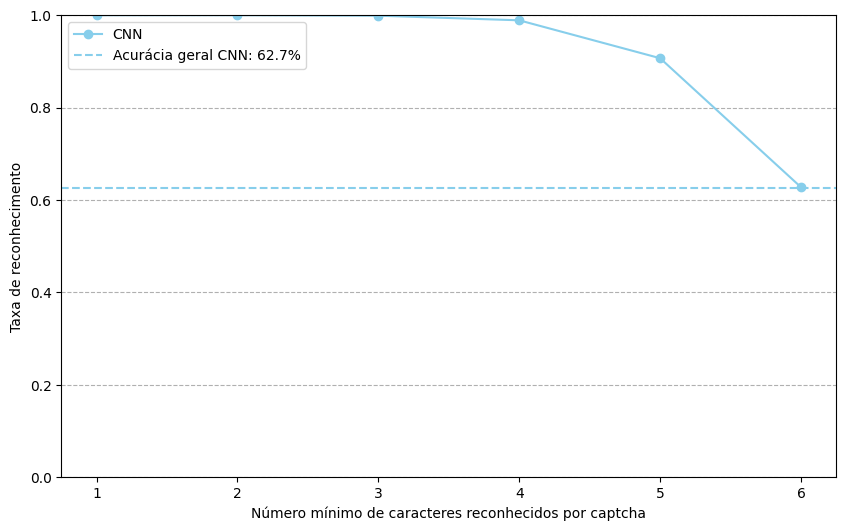

In [34]:
import matplotlib.pyplot as plt

# Calculate recognition rates
max_chars = 6
recognition_rates = []

for min_correct in range(1, max_chars + 1):
    count_correct = df_teste["qtd_acertos"] >= min_correct
    rate = count_correct.mean()
    recognition_rates.append(rate)

# Plot the recognition rates
plt.figure(figsize=(10, 6))

# Plot recognition rate curve
plt.plot(range(1, max_chars + 1), recognition_rates, marker='o', color='skyblue', label='CNN')

plt.axhline(y=0.627, color='skyblue', linestyle='--', label='Acurácia geral CNN: 62.7%')

plt.xlabel('Número mínimo de caracteres reconhecidos por captcha')
plt.ylabel('Taxa de reconhecimento')
plt.grid(axis='y', linestyle='--')
plt.ylim(0, 1)
plt.xticks(range(1, max_chars + 1))

# Update the legend to include overall accuracy
plt.legend()
plt.show()
